In [1]:
import os

import pandas as pd

# Load the uploaded data
file_path = f'{os.getcwd()}/TrendData.xlsx'
data = pd.ExcelFile(file_path)

# Display the sheet names to understand the structure of the file
data.sheet_names


['Training']

In [2]:
# Load the relevant sheet into a DataFrame
df = pd.read_excel(file_path, sheet_name='Training')

# Display the first few rows of the DataFrame to understand its structure
df.head()


,Group,ParticipantID,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6,Session 7,Session 8
0,DO,6170,75.00,81.25,85.71,87.50,88.39,84.82,82.74,84.82
1,DN,514,64.29,73.21,58.04,83.04,73.21,75.89,75.89,73.21
2,DN,3097,58.04,73.21,67.86,76.79,63.39,82.14,76.79,76.79
3,Control,9580,64.29,79.46,77.68,83.93,84.82,83.04,81.25,89.29
4,Control,3691,94.64,90.18,94.64,93.75,97.32,98.21,99.11,96.43


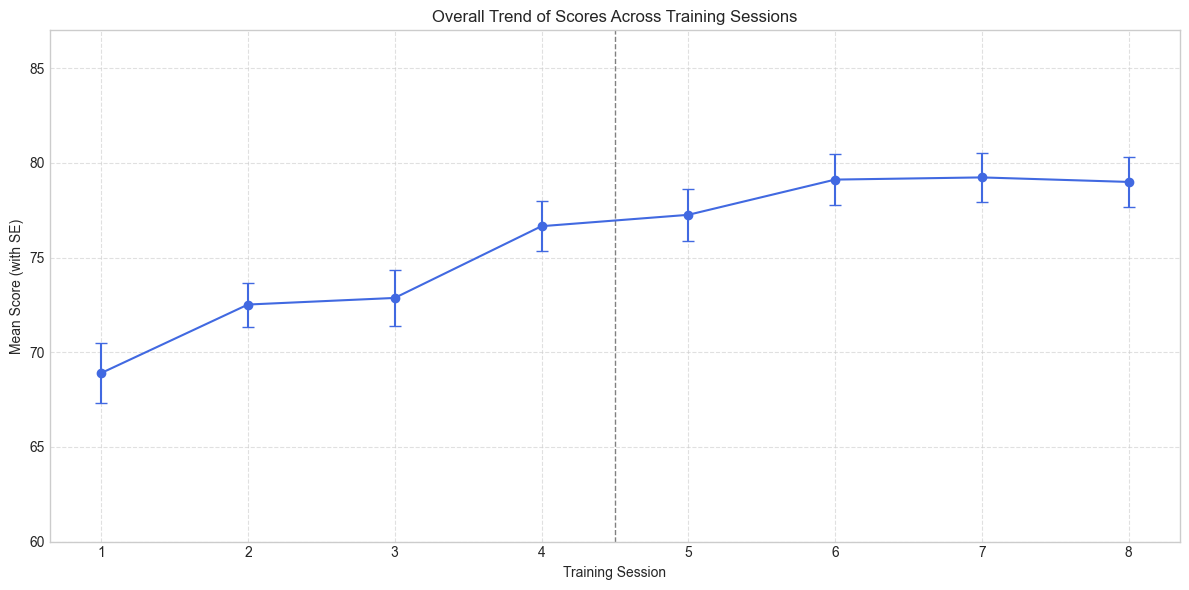

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reshape the data for analysis
df_melted = df.melt(id_vars=['Group', 'ParticipantID'], var_name='Session', value_name='Score')

# Convert session column to a numerical format for analysis
df_melted['Session'] = df_melted['Session'].str.extract('(\d+)').astype(int)

# Calculate mean and standard error across all groups for each session
overall_data = df_melted.groupby('Session').agg(
    Mean_Score=('Score', 'mean'),
    Std_Error=('Score', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

plt.style.use('seaborn-v0_8-whitegrid')

# Plotting the overall trend
plt.figure(figsize=(12, 6))
plt.errorbar(
    overall_data['Session'], overall_data['Mean_Score'],
    yerr=overall_data['Std_Error'],
    label='Overall Average',
    color='royalblue',
    linestyle='-', marker='o', capsize=4
)

# Set y-axis range
plt.ylim(60, 87)

# Add vertical line to split session ranges
plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)

# Customize plot
plt.title('Overall Trend of Scores Across Training Sessions')
plt.xlabel('Training Session')
plt.ylabel('Mean Score (with SE)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('overall_training_sessions_trend.png', dpi=300)
plt.show()


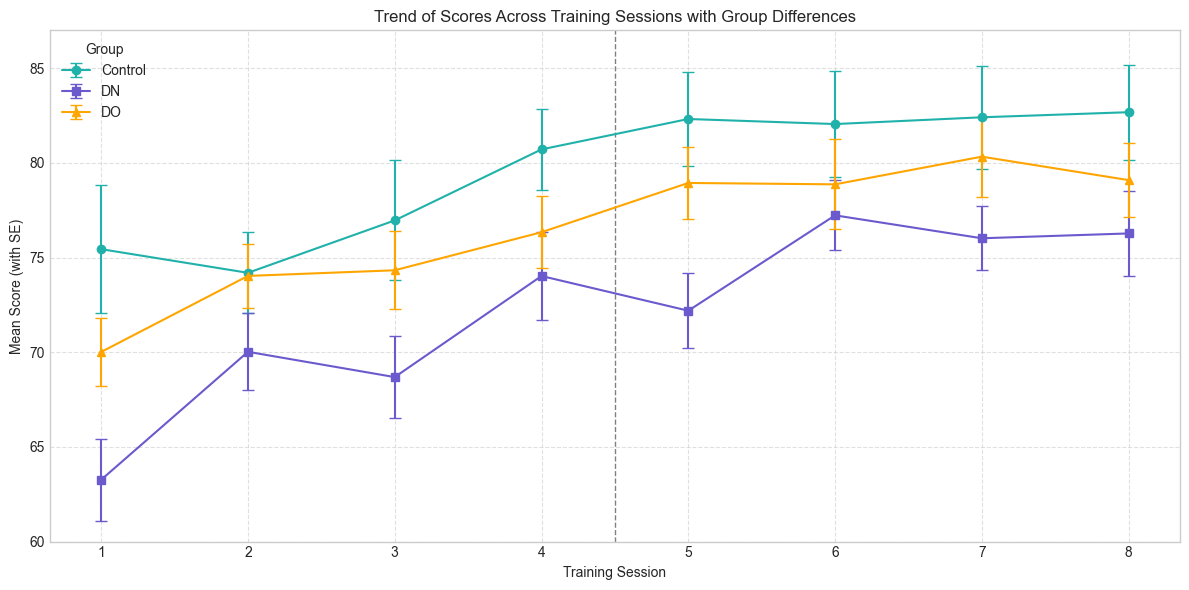

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data for analysis
df_melted = df.melt(id_vars=['Group', 'ParticipantID'], var_name='Session', value_name='Score')

# Convert session column to a numerical format for analysis
df_melted['Session'] = df_melted['Session'].str.extract('(\d+)').astype(int)

# Calculate mean and standard error for each group and session
grouped_data = df_melted.groupby(['Group', 'Session']).agg(
    Mean_Score=('Score', 'mean'),
    Std_Error=('Score', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

plt.style.use('seaborn-v0_8-whitegrid')

# Plotting for each session and group with error bars
plt.figure(figsize=(12, 6))

# Define line styles and markers for each group
group_styles = {
    'Control': {'color': 'lightseagreen', 'linestyle': '-', 'marker': 'o'},
    'DO': {'color': 'orange', 'linestyle': '-', 'marker': '^'},
    'DN': {'color': 'slateblue', 'linestyle': '-', 'marker': 's'}
}

# Plot each group with error bars
for group in grouped_data['Group'].unique():
    group_data = grouped_data[grouped_data['Group'] == group]
    plt.errorbar(
        group_data['Session'], group_data['Mean_Score'],
        yerr=group_data['Std_Error'],
        label=group,
        color=group_styles.get(group, {}).get('color', 'black'),
        linestyle=group_styles.get(group, {}).get('linestyle', '-'),
        marker=group_styles.get(group, {}).get('marker', 'o'),
        capsize=4
    )

# Set y-axis range
plt.ylim(60, 87)

# Add vertical line to split session ranges
plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)

# Customize plot
plt.title('Trend of Scores Across Training Sessions with Group Differences')
plt.xlabel('Training Session')
plt.ylabel('Mean Score (with SE)')
plt.legend(title='Group')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('training_sessions_trend.png', dpi=300)
plt.show()


In [5]:
from scipy.stats import f_oneway, ttest_rel
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Overall improvement analysis (paired t-test between Session 1 and Session 8)
overall_session_1 = df_melted[df_melted['Session'] == 1]['Score']
overall_session_8 = df_melted[df_melted['Session'] == 8]['Score']
overall_ttest = ttest_rel(overall_session_1, overall_session_8)

# ANOVA for each group
anova_results = {}
for group in df['Group'].unique():
    group_data = df_melted[df_melted['Group'] == group]
    model = ols('Score ~ C(Session)', data=group_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[group] = anova_table

# Displaying the results
overall_ttest, anova_results


(TtestResult(statistic=np.float64(-6.259496454962927), pvalue=np.float64(3.5196887448901206e-07), df=np.int64(35)),
 {'DO':                  sum_sq    df         F    PR(>F)
  C(Session)  1030.282462   7.0  3.097537  0.005749
  Residual    4181.426500  88.0       NaN       NaN,
  'DN':                  sum_sq     df        F    PR(>F)
  C(Session)  2194.916114    7.0  5.24176  0.000038
  Residual    6221.227557  104.0      NaN       NaN,
  'Control':                  sum_sq    df         F    PR(>F)
  C(Session)   854.647099   7.0  1.672812  0.129398
  Residual    5255.017190  72.0       NaN       NaN})